### import

In [1]:
import numpy as np 
import pandas as pd 
import sys 
import os 
import logzero 
import wandb 
import pickle 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

### config

In [2]:
from src.utils import noglobal, pickle_load, pickle_save, HydraConfig

In [3]:
class Config():
    version = '002'
    comment = 'test'
    input_dir = '/home/user/work/input/whichbookshouldiread'
    output_dir = f'/home/user/work/output/{version}' 
    seed = 42
    target_col = 'rating'
    wandb_init = {
        "project": "debug",
        "entity": "kuto5046",
        "group": f"exp{version}",
        "dir": output_dir,
        "tags": [],
        "mode": "disabled", 
    }

    n_splits = 5
    use_fold = [0]  # fold1つで終える場合[0], 全てのfoldを実行する場合[0,1,2,3,4]

    # model設定読み込み
    model_config_name = 'lgb_multiclass'  # タスクや使うモデルに応じて変更
    model_config = HydraConfig.get_cnf(config_path='/home/user/work/configs/model/', config_name=model_config_name)
    num_boost_round = model_config['num_boost_round']
    model_name = model_config.name
    model_params = dict(model_config['params'])

    

c = Config()
# c = HydraConfig.get_cnf(config_path='/home/user/work/configs/', config_name='config.yaml')
os.makedirs(c.output_dir, exist_ok=True)
logger = logzero.setup_logger(name='main', logfile=f'{c.output_dir}/result.log', level=10)

/opt/conda/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'lgb_multiclass': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
# 念の為check
c.model_name, c.num_boost_round, c.model_params

('lightgbm',
 3000,
 {'boosting_type': 'gbdt',
  'objective': 'multiclass',
  'metric': 'multi_logloss',
  'colsample_bytree': 0.8,
  'max_depth': 5,
  'subsample': 0.8,
  'min_child_weight': 1,
  'seed': 42,
  'learning_rate': 0.05,
  'verbose': -1,
  'num_class': 10})

### read data

In [5]:
train = pd.read_csv(f'{c.input_dir}/train_ratings.csv')
test = pd.read_csv(f'{c.input_dir}/test_ratings.csv')
user = pd.read_csv(f"{c.input_dir}/users.csv")
book = pd.read_csv(f"{c.input_dir}/books.csv")
train.shape, test.shape

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


((249426, 4), (134307, 3))

In [6]:
c.target_col = 'rating'

### preprocess

In [7]:
from src.features.base import get_categorical_col, get_numerical_col
from src.features.encoder import pp_for_categorical_encoding

In [8]:
train[c.target_col] -= 1

In [9]:
whole = pd.concat([train, test]).reset_index(drop=True)

In [10]:
whole = whole.merge(book, on='book_id', how='left').merge(user, on='user_id', how='left')

In [11]:
cat_cols = get_categorical_col(whole, skip_cols=['id', c.target_col])
numerical_cols = get_numerical_col(whole, skip_cols=['id', c.target_col])

In [12]:
cat_cols

['user_id',
 'book_id',
 'title',
 'author',
 'year',
 'publisher',
 'city',
 'province',
 'country']

In [13]:
whole[cat_cols]

,user_id,book_id,title,author,year,publisher,city,province,country
0,9db527ea34,69173ee3b6,Elusive Swan,Sylvie F. Sommerfield,1987,Kensington Pub Corp (Mm),mechanicsville,maryland,usa
1,3db2595a13,58d33fe06a,The No. 1 Ladies' Detective Agency (Today Show...,Alexander McCall Smith,2003,Anchor,romney,west virginia,usa
2,375781e597,512b5d69de,Roberts' Rules of Lesbian Break-ups,Shelly Roberts,1997,Spinsters Ink Books,cape girardeau,missouri,usa
3,f00ee6360d,98c1419160,The Summons,John Grisham,2002,Dell Publishing Company,san diego,,usa
4,8b893fb104,99c56ce036,"Starman (The Axis Trilogy, Bk 3)",Sara Douglass,2002,Tor Books,springfield,missouri,usa
...,...,...,...,...,...,...,...,...,...
383728,598825e90a,29f4516f72,The Truth: The Only Fitness Book You'll Ever Need,Frank Sepe,2004,Hay House,goodyear,az,usa
383729,0e1ff052ae,d27721acf2,Ella Enchanted,Gail Carson Levine,1997,Schoolastic Inc.,albuquerque,new mexico,usa
383730,0baec5a22d,121a671e06,Croc-Blanc,Jack London,2000,Hemma,houdemont,luxembourg,belgium
383731,967874531a,c414ce067b,Worth Any Price,Lisa Kleypas,2003,Avon,carrollton,georgia,usa


In [14]:
whole['year'].replace("0", np.nan, inplace=True)
whole['year'].replace('DK Publishing Inc', np.nan, inplace=True)

In [15]:
whole['year'] = whole['year'].astype(float)

In [16]:
whole['year'].replace(0, np.nan, inplace=True)

In [17]:
cat_cols = get_categorical_col(whole, skip_cols=['id', c.target_col])
numerical_cols = get_numerical_col(whole, skip_cols=['id', c.target_col])

In [18]:
cat_cols

['user_id',
 'book_id',
 'title',
 'author',
 'publisher',
 'city',
 'province',
 'country']

In [19]:
numerical_cols

['year', 'age']

In [20]:
train = whole[~whole[c.target_col].isna()].reset_index(drop=True)
test = whole[whole[c.target_col].isna()].reset_index(drop=True)

In [21]:
train, test = pp_for_categorical_encoding(train, test, cat_cols)

### feature engineering

In [22]:
from src.features.base import Feature, generate_features, load_datasets
from src.features.encoder import count_encoder, ordinal_encoder, pp_for_categorical_encoding, target_encoder
from src.features.nlp import count_lda_vectorize, tfidf_svd_vectorize, UniversalSentenceEncoder, BertSequenceVectorizer, Sentence2Vec, SCDVEmbedder

2022-10-12 23:21:41.197719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 23:21:41.316857: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 23:21:41.761106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-12 23:21:41.761155: W te

In [23]:
class Numerical(Feature):
    def create_features(self):
        self.train = train[numerical_cols]
        self.test = test[numerical_cols]


class OrdinalEncode(Feature):
    def create_features(self):
        self.train, self.test = ordinal_encoder(train, test, cat_cols)


class CountEncode(Feature):
    def create_features(self):
        self.train, self.test = count_encoder(train, test, cat_cols)


In [24]:
ext = 'pickle'
generate_features(globals(), ext=ext, overwrite=True)

[Numerical] start
[Numerical] done in 0 s
[OrdinalEncode] start
[OrdinalEncode] done in 1 s
[CountEncode] start
[CountEncode] done in 0 s


In [25]:
feats = [
    'OrdinalEncode',
    'Numerical',
    'CountEncode'
]
train_data, test_data = load_datasets(feats, ext=ext)

In [26]:
cat_cols = get_categorical_col(train_data)
cat_cols 

['ordinal_enc_user_id',
 'ordinal_enc_book_id',
 'ordinal_enc_title',
 'ordinal_enc_author',
 'ordinal_enc_publisher',
 'ordinal_enc_city',
 'ordinal_enc_province',
 'ordinal_enc_country']

In [27]:
# 使用する特徴量&label
for f in train_data.columns:
    print(f)

ordinal_enc_user_id
ordinal_enc_book_id
ordinal_enc_title
ordinal_enc_author
ordinal_enc_publisher
ordinal_enc_city
ordinal_enc_province
ordinal_enc_country
year
age
count_enc_user_id
count_enc_book_id
count_enc_title
count_enc_author
count_enc_publisher
count_enc_city
count_enc_province
count_enc_country


In [28]:
train_data[c.target_col] = train[c.target_col].to_numpy()

### cv

In [29]:
from src.cv import get_kfold, get_stratifiedkfold, get_groupkfold
cv = get_stratifiedkfold(train_data, c.target_col, n_splits=c.n_splits)
cv

[(array([     2,      3,      4, ..., 249423, 249424, 249425]),
  array([     0,      1,     12, ..., 249410, 249418, 249420])),
 (array([     0,      1,      2, ..., 249423, 249424, 249425]),
  array([     5,     32,     36, ..., 249415, 249417, 249422])),
 (array([     0,      1,      2, ..., 249419, 249420, 249422]),
  array([     7,     10,     13, ..., 249423, 249424, 249425])),
 (array([     0,      1,      2, ..., 249423, 249424, 249425]),
  array([     3,      6,      8, ..., 249412, 249416, 249419])),
 (array([     0,      1,      3, ..., 249423, 249424, 249425]),
  array([     2,      4,     11, ..., 249411, 249413, 249414]))]

### callback

In [30]:
from src.models.gbdt import get_callbacks
callbacks = get_callbacks(c.model_name)
callbacks

[<function lightgbm.callback.early_stopping.<locals>._callback(env: lightgbm.callback.CallbackEnv) -> None>,
 <function lightgbm.callback.log_evaluation.<locals>._callback(env: lightgbm.callback.CallbackEnv) -> None>,
 <function wandb.integration.lightgbm.wandb_callback.<locals>._callback(env: 'CallbackEnv') -> None>]

### model

In [31]:
from src.models.gbdt import get_model # , LGBModel, XGBModel, CBModel 

model = get_model(c.model_name, c.model_params, c.num_boost_round, cat_cols, c.output_dir, callbacks)

### train

In [32]:
from sklearn.metrics import f1_score, roc_auc_score
def calc_score(true, pred):
    return f1_score(true, pred, average='micro')

In [39]:
def train_pipeline(model, train, test, cv, config, cat_cols, target_col):
    oofs = []
    preds = []
    for i, (idx_train, idx_valid) in enumerate(cv):
        # if i not in [0]:
        #     break 
        if i not in c.use_fold:
            continue 

        wandb.init(**config.wandb_init, name=f'exp{config.version}-fold{i}')
        logger.info("############")
        logger.info(f"fold {i}")
        logger.info("############")

        _train = train.loc[idx_train].reset_index(drop=True)
        _valid = train.loc[idx_valid].reset_index(drop=True)

        # target encoding
        te_cols = cat_cols 
        for col in te_cols:
            _train, _valid = target_encoder(_train, _valid, col, target_col)
            _, test = target_encoder(train, test, col, target_col)

        X_train = _train.drop(target_col, axis=1)
        y_train = _train[target_col]
        X_valid = _valid.drop(target_col, axis=1)
        y_valid = _valid[target_col]
        X_test = test

        model.train(X_train, y_train, X_valid, y_valid)
        model.save(i)
        pred = model.predict(X_valid)

        # evaluate
        score = calc_score(y_valid, pred)
        logger.info(f'fold-{i} score: {score}')
        wandb.log({'CV': score})

        # create oof
        oof_df = pd.DataFrame(pred, index=idx_valid)
        oofs.append(oof_df)

        # pred
        pred_test = model.predict(X_test)
        np.save(f"{c.output_dir}/pred_test_{i}", pred_test)
        preds.append(pred_test)

        if i!=len(cv)-1:
            wandb.finish()

    # oofを保存
    oof = np.array(pd.concat(oofs).sort_index())
    np.save(f"{c.output_dir}/oof", oof)
    return model, oof

In [40]:
model, oof = train_pipeline(model, train_data, test_data, cv, c, cat_cols, c.target_col)

[I 221012 23:24:20 789296633:11] ############
[I 221012 23:24:20 789296633:12] fold 0
[I 221012 23:24:20 789296633:13] ############
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's multi_logloss: 1.53213	valid_1's multi_logloss: 1.69805
[200]	training's multi_logloss: 1.4503	valid_1's multi_logloss: 1.69941
Early stopping, best iteration is:
[120]	training's multi_logloss: 1.51288	valid_1's multi_logloss: 1.69745


[I 221012 23:24:35 789296633:36] fold-0 score: 0.3446057009982761


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Importance'}, xlabel='feature_importance', ylabel='column'>)

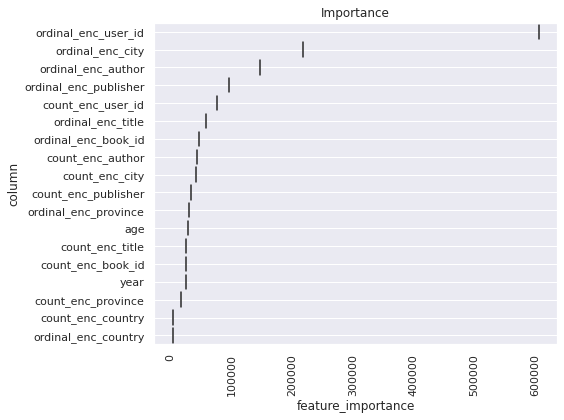

In [35]:
from src.visualize import plot_importance
# catboostは対応していない
plot_importance(model.models, output_dir=c.output_dir)

### inference

In [36]:
preds = []
for i in range(len(cv)):
    if i not in c.use_fold:
        continue
    pred = np.load(f'{c.output_dir}/pred_test_{i}.npy')
    preds.append(pred)
pred_test = np.mean(preds, axis=0)

In [37]:
pred_test = pred_test - 1

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


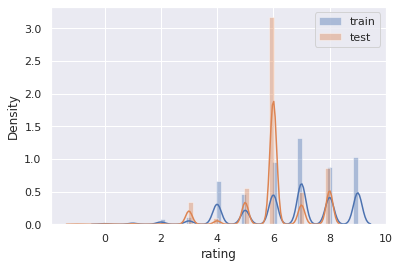

In [38]:
sns.distplot(train[c.target_col], label='train')
sns.distplot(pred_test, label='test')
plt.legend();

### submission

In [ ]:
sub = pd.read_csv(f'{c.input_dir}/sample_submission.csv')
sub[c.target_col] = pred_test
sub.to_csv(f'{c.output_dir}/submission_exp{c.version}.csv', index=False)